In [1]:
# Portfolio Optimisation
# Author Sanket Karve

# Importing all required libraries
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [2]:
# Importing the Portfolio Optimisation Library functions
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter


In [3]:
# Get tickers of required stocks
tickers = ["BSX", "AES", "BRK-B", "SEE", "QQQ", "SPY"]
the_len = len(tickers)
price_data = []

for ticker in range(the_len):
    prices = web.DataReader(tickers[ticker], start="2015-01-01", end="2020-06-06", data_source="yahoo")
    price_data.append(prices.assign(ticker=ticker)[["Adj Close"]])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.head()

,BSX,AES,BRK-B,SEE,QQQ,SPY
Date,,,,,,
2015-01-02,13.22,10.896731,149.169998,39.007454,97.672798,182.746567
2015-01-05,13.81,10.586535,147.000000,38.450211,96.240067,179.446259
2015-01-06,13.70,10.347920,146.839996,38.651180,94.949654,177.756073
2015-01-07,14.03,10.363826,148.880005,38.705990,96.173660,179.971115
2015-01-08,14.59,10.522902,151.369995,39.418530,98.014389,183.164703


In [4]:
# Checking if there are any NAN values in the data
nullin_df = pd.DataFrame(df_stocks, columns=tickers)
print(nullin_df.isnull().sum())

BSX      0
AES      0
BRK-B    0
SEE      0
QQQ      0
SPY      0
dtype: int64


In [5]:
# Annualised Return
mu = expected_returns.mean_historical_return(df_stocks)

mu

BSX      0.220080
AES      0.046950
BRK-B    0.056269
SEE     -0.021147
QQQ      0.179486
SPY      0.105957
dtype: float64

In [6]:
# Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

Sigma

,BSX,AES,BRK-B,SEE,QQQ,SPY
BSX,0.083179,0.040831,0.032342,0.037882,0.038989,0.035822
AES,0.040831,0.107894,0.033947,0.051825,0.032879,0.034954
BRK-B,0.032342,0.033947,0.042922,0.030727,0.032213,0.032550
SEE,0.037882,0.051825,0.030727,0.099930,0.027665,0.029498
QQQ,0.038989,0.032879,0.032213,0.027665,0.044265,0.036123
SPY,0.035822,0.034954,0.032550,0.029498,0.036123,0.033583


In [7]:
# Max Sharpe Ratio - Tangent to the EF
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))  # weight_bounds in negative allows shorting of stocks
sharpe_pfolio = ef1.max_sharpe()  # May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt = ef1.clean_weights()
print(sharpe_pwt)

OrderedDict([('BSX', 0.32559), ('AES', 0.0), ('BRK-B', 0.0), ('SEE', 0.0), ('QQQ', 0.67441), ('SPY', 0.0)])


In [8]:
# Get portfolio performance
ef1.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27


Expected annual return: 19.3%
Annual volatility: 21.5%
Sharpe Ratio: 0.80


(0.19270282272727185, 0.21464742189262567, 0.8045883859423385)

In [9]:
# Minimum Volatility Portfolio
ef2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))  # weight_bounds in negative allows shorting of stocks
minvol = ef2.min_volatility()
minvol_pwt = ef2.clean_weights()
print(minvol_pwt)


OrderedDict([('BSX', 0.0), ('AES', 0.0), ('BRK-B', 0.08024), ('SEE', 0.05239), ('QQQ', 0.0), ('SPY', 0.86737)])


In [10]:
# Get MinVol portfolio performance
ef2.portfolio_performance(verbose=True)  # 2 year risk free rate - Treasury Yield would set risk_free_rate=0.27

Expected annual return: 9.5%
Annual volatility: 18.2%
Sharpe Ratio: 0.41


(0.0953112977218262, 0.1824458162902241, 0.4127872003489814)

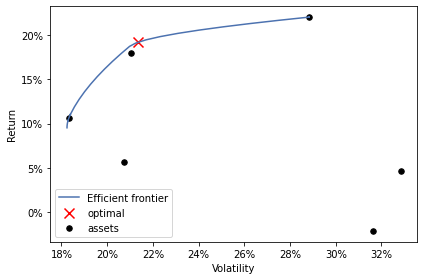

In [11]:
# Plot the Efficient Frontier for visual puposes
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.0%}".format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))

In [12]:
# Get latest prices
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
latest_prices

BSX       38.830002
AES       13.971002
BRK-B    200.660004
SEE       34.743065
QQQ      238.840988
SPY      315.329071
Name: 2020-06-05 00:00:00, dtype: float64

In [13]:
# Sort Solvers
# import cvxpy as cp
# import cvxopt

# print(cp.installed_solvers())

In [16]:
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy

# Max Sharpe Ratio Portfolio Allocation $10,000
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio()
print(allocation_shp)
print("Leftover fund after building Max Sharpe Portfolio is ${:.2f}".format(rem_shp))


{'BSX': 84, 'QQQ': 28}
Leftover fund after building Max Sharpe Portfolio is $50.73


In [18]:
# Min Volatility Portfolio Allocation $10,000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol, latest_prices, total_portfolio_value=10000).lp_portfolio()
print(allocation_minv)
print("Leftover fund after building Min Volatility Portfolio is ${:.2f}".format(rem_minv))


{'BSX': 1, 'BRK-B': 4, 'SEE': 18, 'SPY': 27}
Leftover fund after building Min Volatility Portfolio is $19.27
